In [1]:
import pychemauth
import keras
import sklearn
import pickle
import os
import tqdm
import copy
import imblearn
import pyts
import pathlib

import numpy as np

from pychemauth import utils
from pychemauth.classifier import osr
from pychemauth.datasets import make_pgaa_images

from sklearn.model_selection import GridSearchCV

from pyts.image import GramianAngularField

2024-10-09 15:04:05.686610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.8.0-45-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

tqdm      : 4.66.1
numpy     : 1.26.4
keras     : 2.14.0
pychemauth: 0.0.0b4
sklearn   : 1.3.0
imblearn  : 0.11.0
watermark : 2.4.3
pyts      : 0.13.0



# Load Data

In [3]:
build_from_scratch = False

if build_from_scratch:
    # Build the dataset locally from scratch
    
    # Load the challenge data
    res_challenge = make_pgaa_images(
        transformer=GramianAngularField(method='difference'), 
        exclude_classes=[
            'Biomass', 
            'Coal and Coke', 
            'Concrete', 
            'Dolomitic Limestone',
            'Forensic Glass', 
            'Fuel Oil', 
            'Graphite/Urea Mixture',
            'Lubricating Oil', 
            'Steel', 
            'Titanium Alloy'
        ], # Exclude the ones we already trained on 
        valid_range=(0, 2631), 
        renormalize=True,
        test_size=0.0,
    )
    X_challenge, _, y_challenge, _, _, encoder_challenge = res_challenge

    # Map the y_challenge classes of [0, 1, 2] -> [10, 11, 12]
    y_challenge += 10

    # Split the challenge set (classes [10, 11, 12]) into test/train folds
    Xc_train, Xc_test, yc_train, yc_test = sklearn.model_selection.train_test_split(
        X_challenge, y_challenge, test_size=0.2, stratify=y_challenge, random_state=42, shuffle=True
    )

    # Augment the data directories created in 1_learning_rate_finder
    _ = utils.write_dataset(
        directory='./2d-dataset/train',
        X=Xc_train,
        y=yc_train,
        overwrite=False,
        augment=True
    )

    _ = utils.write_dataset(
        directory='./2d-dataset/test',
        X=Xc_test,
        y=yc_test,
        overwrite=False,
        augment=True
    )
    
    d_train = utils.NNTools.build_loader('./2d-dataset/train', batch_size=30, shuffle=False)
    d_test = utils.NNTools.build_loader('./2d-dataset/test', batch_size=30, shuffle=False)
else:
    # Load dataset from HuggingFace
    from pychemauth.utils import NNTools
    from datasets import load_dataset
    
    dataset_fnames = load_dataset(
      "mahynski/pgaa-sample-gadf-images", 
      split="train",
      token="hf_*", # Enter your own token here
      trust_remote_code=True, # This is important to include
      name='filenames' # This is the default
    )

    d_train = NNTools.XLoader(
        x_files = [entry['filename'] for entry in dataset_fnames],
        y = [entry['label'] for entry in dataset_fnames],
        batch_size=30,
        shuffle=False
    )
    
    dataset_fnames = load_dataset(
      "mahynski/pgaa-sample-gadf-images", 
      split="test",
      token="hf_*", # Enter your own token here
      trust_remote_code=True, # This is important to include
      name='filenames' # This is the default
    )

    d_test = NNTools.XLoader(
        x_files = [entry['filename'] for entry in dataset_fnames],
        y = [entry['label'] for entry in dataset_fnames],
        batch_size=30,
        shuffle=False
    )

# Utilities

In [8]:
def load_model1():
    return utils.NNTools.load('./model1.keras')

def load_model2():
    return utils.NNTools.load('./model2.keras')

def load_model3():
    return utils.NNTools.load('./model3.keras')
                              
def build_classifier(model_loader, ood_type, featurize=False, updated_kwargs={}):
    kwargs = { # Baseline kwargs for OSR
        'clf_prefit':True,
        'known_classes':np.arange(10),
        'inlier_value':True,
        'unknown_class':-1,
        'score_metric':'TEFF',
        'clf_style':'hard',
        'score_using':'all'
    }
        
    if ood_type.lower() == 'softmax':
        outlier_kwargs = {
            'model': None if featurize else model_loader(),
            'alpha': 0.05
        }
        outlier_kwargs.update(updated_kwargs)
        kwargs.update({
            'clf_model': osr.DeepOOD.SoftmaxFeatureClf() if featurize else model_loader(),
            'outlier_model': osr.DeepOOD.Softmax,
            'outlier_kwargs': outlier_kwargs
        })
    elif ood_type.lower() == 'energy':
        outlier_kwargs = {
            'model': None if featurize else model_loader(),
            'alpha': 0.05,
            'T': 1.0
        }
        outlier_kwargs.update(updated_kwargs)
        kwargs.update({
            'clf_model': osr.DeepOOD.EnergyFeatureClf() if featurize else model_loader(),
            'outlier_model': osr.DeepOOD.Energy,
            'outlier_kwargs': outlier_kwargs,
        })
    elif ood_type.lower() == 'dime':
        m_ = model_loader()
        featurizer_model = keras.Model(
            inputs=m_.layers[0].input,
            outputs=m_.layers[-2].input,
        )
        outlier_kwargs = {
            'model': None if featurize else featurizer_model,
            'alpha': 0.05,
            'k': 20
        }
        outlier_kwargs.update(updated_kwargs)
        kwargs.update({
            'clf_model': osr.DeepOOD.DIMEFeatureClf(model_loader=model_loader, input_layer=-2) if featurize else model_loader(),
            'outlier_model': osr.DeepOOD.DIME,
            'outlier_kwargs': outlier_kwargs,
        })
    else:
        raise Exception(f'unrecognized {ood_type}')
        
    return osr.OpenSetClassifier(**kwargs)

def train_compliant(model_loader, d_train, ood_type):
    y_train = []
    for _, y_batch_ in d_train:
        if y_batch_.size > 0:
            y_train.append(y_batch_)
    y_train = np.concatenate(y_train)
    
    if ood_type.lower() == 'softmax':
        featurizer = model_loader()
        param_grid = [{
            'osr__outlier_kwargs': [{'model':None, 'alpha':a} for a in np.logspace(-4, np.log10(0.5), 10)],
        }]
    elif ood_type.lower() == 'energy':
        featurizer = model_loader()
        featurizer.layers[-1].activation = None # Deactivate to get logits
        param_grid = [{
            'osr__outlier_kwargs': [{'model':None, 'alpha':a, 'T':t} for a in np.logspace(-4, np.log10(0.5), 10) for t in [0.1, 0.5, 1.0, 5.0, 10.0, 100.0]],
        }]
    elif ood_type.lower() == 'dime':
        m_ = model_loader()
        featurizer = keras.Model(
            inputs=m_.layers[0].input,
            outputs=m_.layers[-2].input,
        )
        param_grid = [{
            'osr__outlier_kwargs': [{'model':None, 'alpha':a, 'k':k} for a in np.logspace(-4, np.log10(0.5), 10) for k in [1, 5, 10, 20, 50]],
        }]
    else:
        raise Exception(f'unrecognized ood_type {ood_type}')
        
    # Featurize the data for CV
    X_feature = featurizer.predict(d_train)

    pipeline = imblearn.pipeline.Pipeline(
        steps=[
            ("osr", build_classifier(model_loader=model_loader, ood_type=ood_type.lower(), featurize=True)) 
        ]
    )

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
        error_score=0,
        refit=True
    )

    _ = gs.fit(X_feature, y_train)

    optimal_hyperparameters = copy.copy(gs.best_params_['osr__outlier_kwargs'])
    optimal_hyperparameters.pop('model')

    # Retrain the final pipeline in terms of raw input
    final_pipeline = imblearn.pipeline.Pipeline(
        steps=[
            ("osr", build_classifier(model_loader=model_loader, ood_type=ood_type.lower(), featurize=False, updated_kwargs=optimal_hyperparameters))
        ]
    )

    final_pipeline.fit(d_train)

    return final_pipeline

# Results

In [9]:
models = {
    'softmax':{1:None, 2:None, 3:None},
    'energy':{1:None, 2:None, 3:None},
    'dime':{1:None, 2:None, 3:None}
}

fom_test = {
    'softmax':{1:None, 2:None, 3:None},
    'energy':{1:None, 2:None, 3:None},
    'dime':{1:None, 2:None, 3:None}
}

In [10]:
compute = False

if compute:
    # Recompute the results from scratch
    for ood_type in ['dime', 'softmax', 'energy']:
        for i, loader_ in enumerate([load_model1, load_model2, load_model3]):
            models[ood_type][i+1] = train_compliant(loader_, d_train=d_train, ood_type=ood_type)
else:
    # Load the results from HuggingFace
    for i, cnn_base in enumerate(['mobilenetv3small', 'nasnetmobile', 'inceptionv3']):
        for ood_type in ['softmax', 'energy', 'dime']:
            models[ood_type][i+1] = pychemauth.utils.HuggingFace.from_pretrained(
                model_id="mahynski/"+f'pgaa-osr-{cnn_base}-{ood_type}'
            )

2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 71ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 32ms/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 1s 1s/step


2024-09-27 16:53:46.622300: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6640224000 exceeds 10% of free system memory.
2024-09-27 16:53:47.226975: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6650327040 exceeds 10% of free system memory.
2024-09-27 16:53:47.227040: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6680682240 exceeds 10% of free system memory.
2024-09-27 16:53:47.227093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6700957440 exceeds 10% of free system memory.
2024-09-27 16:53:50.581475: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6640224000 exceeds 10% of free system memory.


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 76ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 76ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 96ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 100ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 122ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 166ms/step


2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 101ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 81ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 34ms/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


9/9 [==============================] - 129s 14s/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


9/9 [==============================] - 410s 45s/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


9/9 [==============================] - 412s 45s/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


9/9 [==============================] - 129s 14s/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


9/9 [==============================] - 403s 44s/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


9/9 [==============================] - 414s 45s/step


Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 34s 34s/step


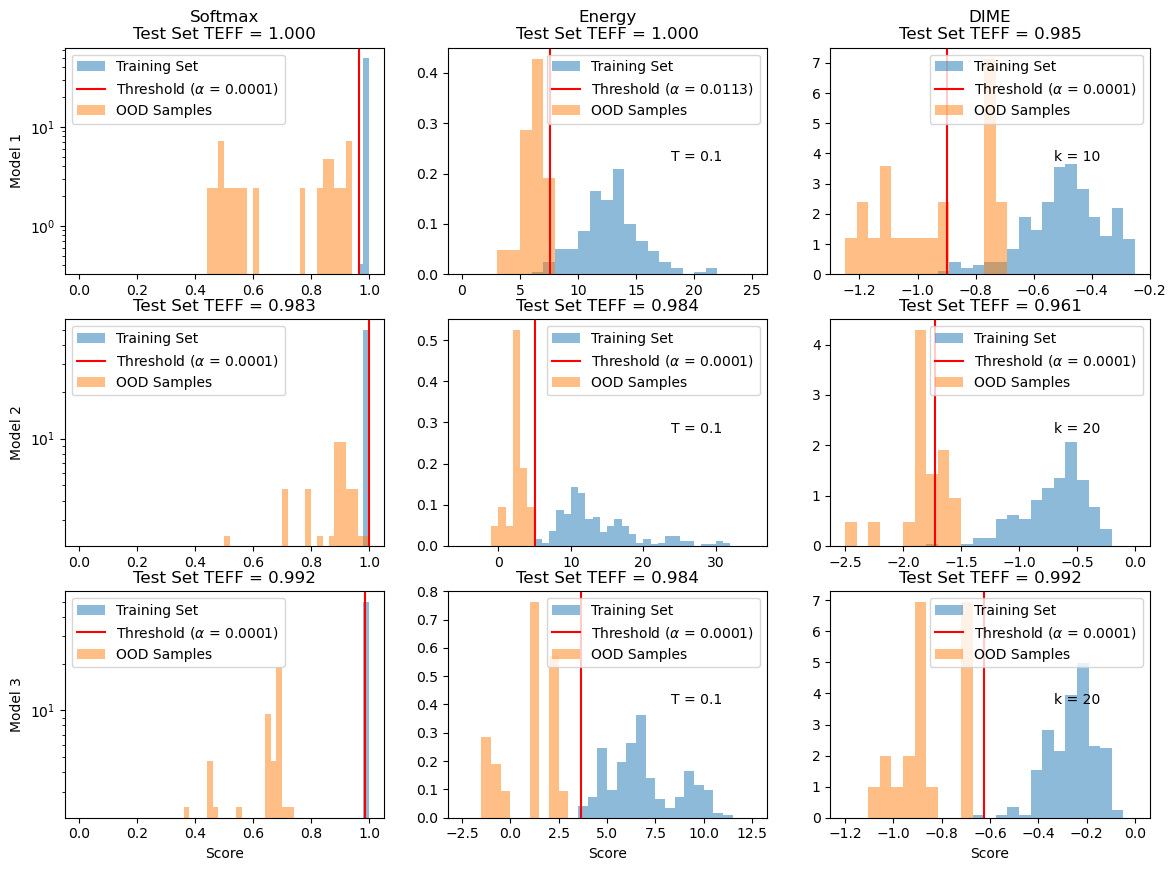

In [129]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))

# Evaluate performances of each final model on the test set (which includes known unknowns)
y_test = []
for _, y_batch_ in d_test:
    if y_batch_.size > 0:
        y_test.append(y_batch_)
y_test = np.concatenate(y_test)
    
# Training set includes some of the challenge examples but only the knowns are plotted here
# ALl challenge samples are plotted as one, but this was split between test/train
for col_, ood_type in enumerate(['softmax', 'energy', 'dime']):
    for model_idx_ in range(3):
        fom_test[ood_type][model_idx_+1] = models[ood_type][model_idx_+1].named_steps['osr'].figures_of_merit(
            models[ood_type][model_idx_+1].predict(d_test), 
            y_test
        )
        
        teff = fom_test[ood_type][model_idx_+1]["TEFF"]
        if ood_type == 'softmax': 
            title_ = "Softmax\n" if model_idx_ == 0 else ""
            bins = np.linspace(0, 1.0, 50+1)
            axes[model_idx_][col_].set_yscale('log')
        
        if ood_type == 'energy':
            title_ = "Energy\n" if model_idx_ == 0 else ""
            T = models[ood_type][model_idx_+1].named_steps['osr'].get_params()['outlier_kwargs']['T']
            if model_idx_ == 0:
                bins = np.linspace(0, 25, 25+1)
                axes[model_idx_][col_].text(0.7, 0.5, f'T = {T}', transform=axes[model_idx_][col_].transAxes)
            elif model_idx_ == 1:
                bins = np.linspace(-5, 35, 40+1)
                axes[model_idx_][col_].text(0.7, 0.5, f'T = {T}', transform=axes[model_idx_][col_].transAxes)
            else:
                bins = np.linspace(-2.5, 12.5, 30+1)
                axes[model_idx_][col_].text(0.7, 0.5, f'T = {T}', transform=axes[model_idx_][col_].transAxes)
        
        if ood_type == 'dime':
            title_ = "DIME\n" if model_idx_ == 0 else ""
            k = models[ood_type][model_idx_+1].named_steps['osr'].get_params()['outlier_kwargs']['k']
            if model_idx_ == 0:
                bins = np.linspace(-1.25, -0.25, 25+1)
                axes[model_idx_][col_].text(0.7, 0.5, f'k = {k}', transform=axes[model_idx_][col_].transAxes)
            elif model_idx_ == 1:
                bins = np.linspace(-2.5, 0.0, 25+1)
                axes[model_idx_][col_].text(0.7, 0.5, f'k = {k}', transform=axes[model_idx_][col_].transAxes)
            else:
                bins = np.linspace(-1.2, 0.0, 25+1)
                axes[model_idx_][col_].text(0.7, 0.5, f'k = {k}', transform=axes[model_idx_][col_].transAxes)
        
        _ = models[ood_type][model_idx_+1].named_steps['osr'].fitted_outlier_model.visualize(
            X_test=X_challenge,
            test_label='OOD Samples',
            ax=axes[model_idx_][col_],
            bins=bins,
            density=True
        )
        axes[model_idx_][col_].set_title(title_+f"Test Set TEFF = {'%.3f'%teff}")
        
        if model_idx_ < 2:
            axes[model_idx_][col_].set_xlabel('')
            
        if col_ == 0:
            axes[model_idx_][col_].set_ylabel(f'Model {model_idx_+1}')
        else:
            axes[model_idx_][col_].set_ylabel('')

In [130]:
# fig.savefig('ood.png', dpi=300)

# Confusion Matrix

In [131]:
df = fom_test['dime'][3]['CM'].copy()

In [132]:
index_map = {
    0: 'Biomass',
    1: 'Coal & Coke',
    2: 'Concrete',
    3: 'Dolomitic Limestone',
    4: 'Forensic Glass',
    5: 'Fuel Oil',
    6: 'Graphite/Urea Mixture',
    7: 'Lubricating Oil',
    8: 'Steel',
    9: 'Titanium Alloy',
    10: 'Carbon Powder',
    11: 'Phosphate Rock',
    12: 'Zircaloy',
    -1: "Unknown"
}

In [133]:
df.rename(index=index_map).rename(columns=index_map).style.set_properties(**{'text-align': 'center'})

,Biomass,Coal & Coke,Concrete,Dolomitic Limestone,Forensic Glass,Fuel Oil,Graphite/Urea Mixture,Lubricating Oil,Steel,Titanium Alloy,Unknown
Biomass,5,0,0,0,0,0,0,0,0,0,1
Coal & Coke,0,19,0,0,0,0,0,0,0,0,0
Concrete,0,0,8,0,0,0,0,0,0,0,0
Dolomitic Limestone,0,0,0,3,0,0,0,0,0,0,0
Forensic Glass,0,0,0,0,4,0,0,0,0,0,0
Fuel Oil,0,0,0,0,0,5,0,0,0,0,0
Graphite/Urea Mixture,0,0,0,0,0,0,3,0,0,0,0
Lubricating Oil,0,0,0,0,0,0,0,8,0,0,0
Steel,0,0,0,0,0,0,0,0,3,0,0
Titanium Alloy,0,0,0,0,0,0,0,0,0,2,0


# Save to HuggingFace

In [ ]:
# This is how models were saved to HuggingFace
# for i, cnn_base in enumerate(['mobilenetv3small', 'nasnetmobile', 'inceptionv3']):
#     for ood_type in ['softmax', 'energy', 'dime']:
#         pychemauth.utils.HuggingFace.push_to_hub(
#             model=models[ood_type][i+1],
#             repo_name=f'pgaa-osr-{cnn_base}-{ood_type}',
#             namespace='mahynski',
#             token='hf_*'
#         )